## Определение пола говорящего

### Необходимые импорты и установка системных переменных

In [1]:
import os
os.environ['HF_HOME'] = '/home/jovyan/work/HF_cache/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import timit_utils as tu

import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

from scipy.io.wavfile import write

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier

import nemo.collections.asr as nemo_asr

import pickle

_TIMIT_PATH = './data/lisa/data/timit/raw/TIMIT'
DATA_PATH = './data/timit_age'

In [3]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')
device

device(type='cuda', index=0)

In [4]:
# Зафиксируем рандомы
import random
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Данные

Для экспериментов и обучения используется датасет TIMIT, который содержит в общей сложности 6300 предложений, по 10 предложений, произнесенных каждым из 630 носителей из 8 основных диалектных регионов Соединенных Штатов.

In [5]:
data_path=_TIMIT_PATH
doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
corpus = tu.Corpus(data_path)

Извлечем нужные данные (пол и возраст) из разметки

In [6]:
with open(doc_file_path) as f:
    lines = f.readlines()
    id_age_dict = dict(
        [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
        for tmp in lines[39:]])
    id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in lines[39:]])

Возраст (три возрастных интервала) пригодится для другой задачи

In [7]:
def clasterize_by_age(age):
    if age <= 25:
        cl_age = 0
    if 25 < age <= 40:
        cl_age = 1
    if 40 < age:
        cl_age = 2
    return int(cl_age)

Мэппинг меток пола в классы

In [8]:
sex_dict = {'M': 1,
            'F': 0}

Загрузим две модели - SpeakerNet и TitaNet - для получения эмбеддингов спикеров.

In [8]:
speakernet_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name="speakerverification_speakernet")
titanet_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name='titanet_large')

[NeMo I 2023-12-06 10:56:01 cloud:58] Found existing object /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/speakerverification_speakernet/a8330fa516557b963a89ccbf0fcbe2f2/speakerverification_speakernet.nemo.
[NeMo I 2023-12-06 10:56:01 cloud:64] Re-using file from: /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/speakerverification_speakernet/a8330fa516557b963a89ccbf0fcbe2f2/speakerverification_speakernet.nemo
[NeMo I 2023-12-06 10:56:01 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-12-06 10:56:01 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /ws/manifests/raid/combined/train_manifest.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 8
    augmentor:
      noise:
        manifest_path: /ws/manifests/raid/musan/musan_music_noise_manifest_dur8.json
        prob: 0.2
        min_snr_db: 5
        max_snr_db: 15
    num_workers: 4
    
[NeMo W 2023-12-06 10:56:01 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /ws/manifests/raid/voxceleb/small_manifest.json
    sample_rate: 16000
    labels: null
    batch_size:

[NeMo I 2023-12-06 10:56:01 features:289] PADDING: 16
[NeMo I 2023-12-06 10:56:04 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/speakerverification_speakernet/a8330fa516557b963a89ccbf0fcbe2f2/speakerverification_speakernet.nemo.
[NeMo I 2023-12-06 10:56:04 cloud:58] Found existing object /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.
[NeMo I 2023-12-06 10:56:04 cloud:64] Re-using file from: /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo
[NeMo I 2023-12-06 10:56:04 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-12-06 10:56:05 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-12-06 10:56:05 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2023-12-06 10:56:05 features:289] PADDING: 16
[NeMo I 2023-12-06 10:56:06 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.


In [9]:
def create_wav_file(raw_audio, output_path, sampling_rate=16000):
    """
    Создание файла WAV из данных raw_audio.

    :param raw_audio: Данные raw_audio
    :param sampling_rate: Частота дискретизации аудио
    :param output_path: Путь для сохранения файла WAV
    """
    # Нормализация данных в диапазон от -1 до 1
    normalized_audio = raw_audio / np.max(np.abs(raw_audio))

    # Преобразование в 16-битный формат
    audio_data = (normalized_audio * 32767).astype(np.int16)

    # Сохранение в файл WAV
    write(output_path, sampling_rate, audio_data)

Сформируем датасет

In [29]:
data = []
k = 0
for mode in ['train', 'valid', 'test']:
    
    if mode == 'train':
        people = [corpus.train.person_by_index(i) for i in range(350)]
    if mode == 'valid':
        people = [corpus.train.person_by_index(i) for i in range(350, 400)]
    if mode == 'test':
        people = [corpus.test.person_by_index(i) for i in range(150)]

    for person in tqdm_notebook(people):
        try:
            target2 = sex_dict[id_sex_dict[person.name]]
            age = id_age_dict[person.name]
            target = clasterize_by_age(age)
            for i in range(len(person.sentences)):
                raw_audio = person.sentence_by_index(i).raw_audio
                wav_path = os.path.join(DATA_PATH, f'audio/{k:06}.wav')
                create_wav_file(raw_audio, wav_path)
                sn_emb = ';'.join(map(str, speakernet_model.get_embedding(wav_path).squeeze().detach().cpu().tolist()))
                tn_emb = ';'.join(map(str, titanet_model.get_embedding(wav_path).squeeze().detach().cpu().tolist()))
                data.append({'mode': mode,
                             'path': f'audio/{k:06}.wav',
                             'target': target,
                             'target2': target2,
                             'age': age,
                             'sn_emb': sn_emb,
                             'tn_emb': tn_emb})
                k += 1
                
        except:
              print(person.name, target)

[NeMo W 2023-12-06 11:11:16 nemo_logging:349] /tmp/ipykernel_2287010/3090388587.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
    Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
      for person in tqdm_notebook(people):
    


  0%|          | 0/350 [00:00<?, ?it/s]

[NeMo W 2023-12-06 11:14:13 nemo_logging:349] /tmp/ipykernel_2287010/3090388587.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
    Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
      for person in tqdm_notebook(people):
    


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [30]:
# сохранение датасета
pd.DataFrame(data).to_csv(os.path.join(DATA_PATH, 'voice_embs.csv'), index=False)

In [9]:
# загрузка датасета
df = pd.read_csv(os.path.join(DATA_PATH, 'voice_embs.csv'))

In [10]:
len(df)

5500

In [11]:
df_train = df[df['mode'] == 'train']
df_val = df[df['mode'] == 'valid']

In [12]:
X_train_sn = [[float(y) for y in x.split(';')] for x in df_train['sn_emb'].tolist()]
X_train_tn = [[float(y) for y in x.split(';')] for x in df_train['tn_emb'].tolist()]
y_train = [x for x in df_train['target2'].tolist()]
X_val_sn = [[float(y) for y in x.split(';')] for x in df_val['sn_emb'].tolist()]
X_val_tn = [[float(y) for y in x.split(';')] for x in df_val['tn_emb'].tolist()]
y_val = [x for x in df_val['target2'].tolist()]

Распределение классов

<Axes: >

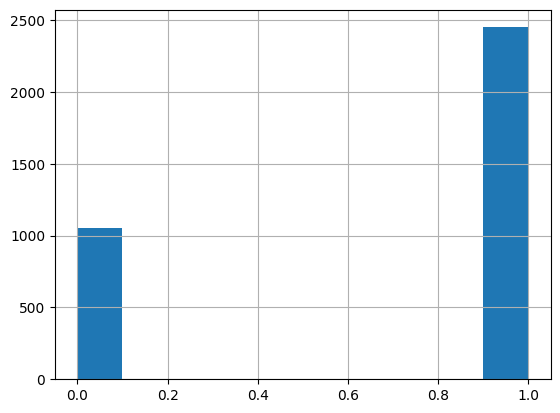

In [13]:
df[df['mode'] == 'train']['target2'].hist()

Применение PCA и построение диаграммы рассеивания

In [13]:
from sklearn.decomposition import PCA
clr_dict = {0: 'r', 1: 'g', 2: 'b'}
clrs = [clr_dict[y] for y in y_train]

In [14]:
pca = PCA(n_components=2)
tn_pca = pca.fit_transform(X_train_tn)

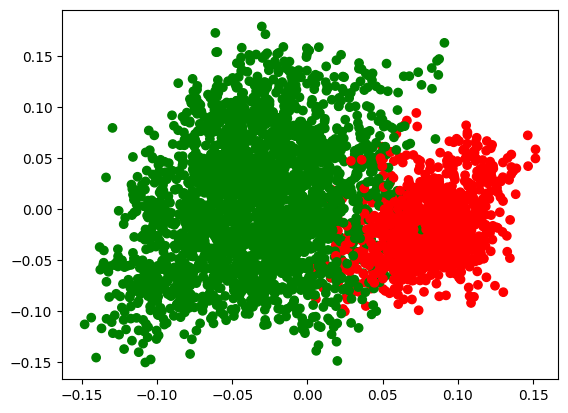

In [15]:
plt.scatter(tn_pca[:, 0], tn_pca[:, 1], c=clrs)
plt.show()

In [16]:
pca = PCA(n_components=2)
sn_pca = pca.fit_transform(X_train_sn)

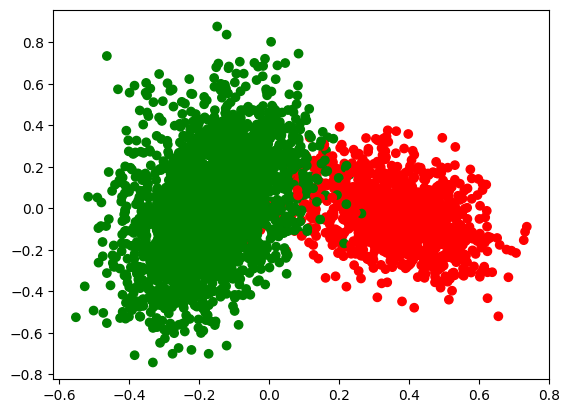

In [17]:
plt.scatter(sn_pca[:, 0], sn_pca[:, 1], c=clrs)
plt.show()

### Baseline - константный классификатор: y = 1

In [17]:
accuracy_score(y_val, [1] * len(y_val))

0.62

### kNN

Подбор гиперпараметров

In [39]:
best_acc = 0.0
for metric in ['minkowski', 'cosine']:
    for n_neighbors in range(1, 50):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train_tn, y_train)
        score = knn.score(X_val_tn, y_val)
        if score > best_acc + 0.01:
            best_acc = score
            best_hparams = {'metric': metric,
                            'n_neighbors': n_neighbors,
                            'accuracy': best_acc}
print(best_hparams)            

{'metric': 'minkowski', 'n_neighbors': 1, 'accuracy': 0.996}


In [40]:
best_acc = 0.0
for metric in ['minkowski', 'cosine']:
    for n_neighbors in range(1, 50):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train_sn, y_train)
        score = knn.score(X_val_sn, y_val)
        if score > best_acc + 0.01:
            best_acc = score
            best_hparams = {'metric': metric,
                            'n_neighbors': n_neighbors,
                            'accuracy': best_acc}
print(best_hparams)     

{'metric': 'minkowski', 'n_neighbors': 1, 'accuracy': 0.994}


Сохранение лучшего классификатора

In [43]:
knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski')
knn.fit(X_train_tn, y_train)
pickle.dump(knn, open('weights/knn_sex_tn.pkl', 'wb'))

```
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
```

Проверка на тесте

In [12]:
df_test = df[df['mode'] == 'test']
X_test_tn = [[float(y) for y in x.split(';')] for x in df_test['tn_emb'].tolist()]
y_test = [x for x in df_test['target2'].tolist()]

In [13]:
age_model = pickle.load(open('./weights/knn_sex_tn.pkl', 'rb'))
score = age_model.score(X_test_tn, y_test)
print(score)

1.0
